# Predicting House Prices

In this project we will utilise Linear Regression to predict house sale prices and then work to improve accuracy. 

We will be working with the **Ames Housing Dataset**, which was compiled by [Dean De Cock](https://www.truman.edu/faculty-staff/decock/) for data science education, and has been used in [Kaggle competitions](https://www.kaggle.com/c/home-data-for-ml-course).

You can download the dataset [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt) and read about the columns [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

Let's start by reading in the data and creating the initial model. 

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('Ameshousing.txt', delimiter='\t')

In [3]:
# creating a function to output our initial training dataset
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    # selecting only numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    train_predictions = lr.predict(train[features])
    test_predictions = lr.predict(test[features])
    train_rmse = np.sqrt(mean_squared_error(train['SalePrice'], train_predictions))
    test_rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))
    
    return test_rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

57088.25161263909

## Feature Engineering

After building the intial model, the next step is to review the data and update to a second version which will: 
- Remove columns with more than 5% missing values 
- Drop any text columns with 1 or more missing values
- Fill in null values with the most common value from the respective numeric column
- Remove columns with data leakage
- Create new columns to provide additional features for the model

In [4]:
# Creating a series of null values
df_null_counts = df.isnull().sum()

In [5]:
# Filter to drop columns containing > 5% missing values
cols_to_drop = df_null_counts[(df_null_counts > len(df)/20)].sort_values()
print(df.shape)
df = df.drop(cols_to_drop.index, axis=1)
print(df.shape)

(2930, 82)
(2930, 71)


In [6]:
# Removing string columns with any null values
text_cols = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
cols_to_drop_2 = text_cols[text_cols > 0]
print(df.shape)
df = df.drop(cols_to_drop_2.index, axis=1)
print(df.shape)

(2930, 71)
(2930, 64)


In [7]:
# Identifying numeric columns to update
numeric_cols = df.select_dtypes(include=['integer', 'float']).isnull().sum()
cols_to_update = numeric_cols[(numeric_cols < len(df)/20) & (numeric_cols > 0)].sort_values()
cols_to_update

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [8]:
values_dict = df[cols_to_update.index].mode().to_dict(orient='records')[0]
values_dict

{'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Mas Vnr Area': 0.0}

In [9]:
df = df.fillna(values_dict)
df.isnull().sum().value_counts()

0    64
dtype: int64

In [10]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [11]:
# Adding a new feature displaying length of time between construction and remodelling (years)
years_until_remod = df['Year Remod/Add'] - df['Year Built']

# Adding a new feature displaying length of time between remodelling and selling (years)
df['years_until_sold'] = years_sold
df['year_until_remod'] = years_until_remod

df = df.drop([1702, 2180, 2181], axis=0)

In [12]:
# Drop the original year columns as they are no longer needed
df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)

In [13]:
# Drop columns which aren't useful for LR, or leak information about the sale

df = df.drop(['PID', 'Order'], axis=1)
df = df.drop(['Mo Sold', 'Yr Sold', 'Sale Condition', 'Sale Type'], axis=1)

In [14]:
# Updating the transform_features function with a threshold for maximum null values
def transform_features(df):
    df_null_counts = df.isnull().sum()
    cols_to_drop = df_null_counts[(df_null_counts > len(df)/20)].sort_values()
    df = df.drop(cols_to_drop.index, axis=1)
    
    text_cols = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    cols_to_drop_2 = text_cols[text_cols > 0]
    df = df.drop(cols_to_drop_2.index, axis=1)
    
    numeric_cols = df.select_dtypes(include=['integer', 'float']).isnull().sum()
    cols_to_update = numeric_cols[(numeric_cols < len(df)/20) & (numeric_cols > 0)].sort_values()
    values_dict = df[cols_to_update.index].mode().to_dict(orient='records')[0]
    df = df.fillna(values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_sold[years_sold < 0]
    years_until_remod = df['Year Remod/Add'] - df['Year Built']

    df['years_until_sold'] = years_sold
    df['year_until_remod'] = years_until_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    df = df.drop(['Year Built', 'Year Remod/Add'], axis=1)
    df = df.drop(['PID', 'Order','Mo Sold', 'Yr Sold', 'Sale Condition', 'Sale Type'], axis=1)
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    # selecting only numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    train_predictions = lr.predict(train[features])
    test_predictions = lr.predict(test[features])
    train_rmse = np.sqrt(mean_squared_error(train['SalePrice'], train_predictions))
    test_rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))
    
    return test_rmse

df = pd.read_csv('AmesHousing.txt', delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

55275.367312413066

## Feature Selection

Now the data has been cleaned and transformed, let's look at the correlation between numerical columns in our dataset. 
Additionally any numerical data which can be classified as categorical needs to be transformed.

In [15]:
numerical_df = transform_df.select_dtypes(include=['integer', 'float'])
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MS SubClass       2927 non-null   int64  
 1   Lot Area          2927 non-null   int64  
 2   Overall Qual      2927 non-null   int64  
 3   Overall Cond      2927 non-null   int64  
 4   Mas Vnr Area      2927 non-null   float64
 5   BsmtFin SF 1      2927 non-null   float64
 6   BsmtFin SF 2      2927 non-null   float64
 7   Bsmt Unf SF       2927 non-null   float64
 8   Total Bsmt SF     2927 non-null   float64
 9   1st Flr SF        2927 non-null   int64  
 10  2nd Flr SF        2927 non-null   int64  
 11  Low Qual Fin SF   2927 non-null   int64  
 12  Gr Liv Area       2927 non-null   int64  
 13  Bsmt Full Bath    2927 non-null   float64
 14  Bsmt Half Bath    2927 non-null   float64
 15  Full Bath         2927 non-null   int64  
 16  Half Bath         2927 non-null   int64  


In [16]:
corrs = numerical_df.corr()['SalePrice'].abs().sort_values()
corrs

BsmtFin SF 2        0.006127
Misc Val            0.019273
3Ssn Porch          0.032268
Bsmt Half Bath      0.035875
Low Qual Fin SF     0.037629
Pool Area           0.068438
MS SubClass         0.085128
Overall Cond        0.101540
Screen Porch        0.112280
Kitchen AbvGr       0.119760
Enclosed Porch      0.128685
Bedroom AbvGr       0.143916
Bsmt Unf SF         0.182751
year_until_remod    0.240055
Lot Area            0.267520
2nd Flr SF          0.269601
Bsmt Full Bath      0.276258
Half Bath           0.284871
Open Porch SF       0.316262
Wood Deck SF        0.328183
BsmtFin SF 1        0.439284
Fireplaces          0.474831
TotRms AbvGrd       0.498574
Mas Vnr Area        0.506983
Full Bath           0.546118
years_until_sold    0.558979
1st Flr SF          0.635185
Garage Area         0.641425
Total Bsmt SF       0.644012
Garage Cars         0.648361
Gr Liv Area         0.717596
Overall Qual        0.801206
SalePrice           1.000000
Name: SalePrice, dtype: float64

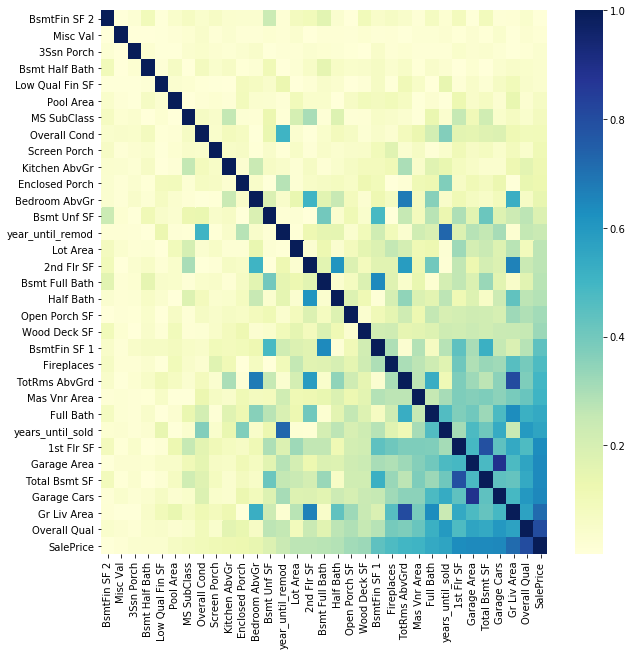

In [17]:
# Creating a heatmap for all columns with a correlation of >= 0.3 with Sale Price
import seaborn as sns
corrmat = transform_df[corrs.index].corr().abs()
plt.figure(figsize=[10,10])
sns.heatmap(corrmat, cmap='YlGnBu')

From the heatmap above, `Overall Qual` and `Gr Liv Area` appear to have particularly strong correlations with `Sale Price`. 

There is strong collinearity between some of the features, and therefore it is appropriate to consider dropping some of these. Now let's look at categorical features.

In [18]:
corrs[corrs > 0.4]

BsmtFin SF 1        0.439284
Fireplaces          0.474831
TotRms AbvGrd       0.498574
Mas Vnr Area        0.506983
Full Bath           0.546118
years_until_sold    0.558979
1st Flr SF          0.635185
Garage Area         0.641425
Total Bsmt SF       0.644012
Garage Cars         0.648361
Gr Liv Area         0.717596
Overall Qual        0.801206
SalePrice           1.000000
Name: SalePrice, dtype: float64

In [19]:
transform_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MS SubClass       2927 non-null   int64  
 1   MS Zoning         2927 non-null   object 
 2   Lot Area          2927 non-null   int64  
 3   Street            2927 non-null   object 
 4   Lot Shape         2927 non-null   object 
 5   Land Contour      2927 non-null   object 
 6   Utilities         2927 non-null   object 
 7   Lot Config        2927 non-null   object 
 8   Land Slope        2927 non-null   object 
 9   Neighborhood      2927 non-null   object 
 10  Condition 1       2927 non-null   object 
 11  Condition 2       2927 non-null   object 
 12  Bldg Type         2927 non-null   object 
 13  House Style       2927 non-null   object 
 14  Overall Qual      2927 non-null   int64  
 15  Overall Cond      2927 non-null   int64  
 16  Roof Style        2927 non-null   object 


In [20]:
transform_df = transform_df.drop(corrs[corrs < 0.4].index, axis=1)

In [21]:
# Create a list of categorical columns based on the documentation
cat_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

Now the columns which should be categorical are stored as a list, the next step is to decide which should be converted to categorical data type. 

The first step is to look at the unique value counts of each column, as any which have lots of unique values would mean we need to create a high volume of columns to add back into the data frame. Likewise if any are 95% the same values then the low variability means it won't add much benefit to keep in our model.

The second step is to explore which columns are currently numerical but actually refer to categorical information. 

In [22]:
# Which categorical columns are still in transform_df?
transform_cat_cols = []
for col in cat_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

# How many unique values for each categorical column?
unique_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

# Set a threshold for unique values and drop anything above this
drop_nonunique_cols = unique_counts[unique_counts > 10].index
transform_df = transform_df.drop(drop_nonunique_cols, axis=1)

In [23]:
# Select text cols and convert to categorical:
text_cols = transform_df.select_dtypes(include=['object'])

for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')

transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

In [24]:
# Updating the model
def transform_features(df):
    df_null_counts = df.isnull().sum()
    cols_to_drop = df_null_counts[(df_null_counts > len(df)/20)].sort_values()
    df = df.drop(cols_to_drop.index, axis=1)
    
    text_cols = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    cols_to_drop_2 = text_cols[text_cols > 0]
    df = df.drop(cols_to_drop_2.index, axis=1)
    
    numeric_cols = df.select_dtypes(include=['integer', 'float']).isnull().sum()
    cols_to_update = numeric_cols[numeric_cols > 0].sort_values()
    values_dict = df[cols_to_update.index].mode().to_dict(orient='records')[0]
    df = df.fillna(values_dict)
    
    df['years_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    df['years_until_sold'] = df['Yr Sold'] - df['Year Remod/Add']
    df = df.drop(['PID', 'Order'], axis=1)
    df = df.drop(['Mo Sold', 'Yr Sold', 'Sale Condition', 'Sale Type'], axis=1)
    return df

def select_features(df, corrs_threshold=0.4, unique_threshold=10):
    numerical_df = df.select_dtypes(include=['integer', 'float'])
    corrs = numerical_df.corr()['SalePrice'].abs().sort_values()
    corrs[corrs > 0.4]
    df = df.drop(corrs[corrs < 0.4].index, axis=1)
    
    cat_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    transform_cat_cols = []
    for col in cat_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    unique_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

    drop_nonunique_cols = unique_counts[unique_counts > 10].index
    df = df.drop(drop_nonunique_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])

    for col in text_cols:
        df[col] = df[col].astype('category')

    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df, k=0):
    # selecting only numeric columns
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[0:1460]
        test = df[1460:]
    
        lr.fit(train[features], train['SalePrice'])
        test_predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))
        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1)
        train = shuffled_df[:1460]
        test = shuffled_df[1460:]
        lr.fit(train[features], train['SalePrice'])
        predictions_one = lr.predict(train[features])
        predictions_two = lr.predict(test[features])
        predictions_one_rmse = np.sqrt(mean_squared_error(train['SalePrice'], predictions_one))
        predictions_two_rmse = np.sqrt(mean_squared_error(test['SalePrice'], predictions_two))
        avg_rmse = np.mean([predictions_one_rmse, predictions_two_rmse])
        
        print(predictions_one_rmse, predictions_two_rmse)
        return(avg_rmse)
        
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            train_predictions = lr.predict(train[features])
            test_predictions = lr.predict(test[features])
            train_predictions_rmse = np.sqrt(mean_squared_error(train['SalePrice'], train_predictions))
            test_predictions_rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))
            rmse_values.append(test_predictions_rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv('AmesHousing.txt', delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)
rmse

[57557.73817222145, 59059.02880120656, 59024.855368381184, 50839.21387612647]


56620.209054483916